# Simple example
Please find below a simple example of an inverted pendulum. The goal is, by using only 
side pushes, to bring the wand upward. 

The ocp to solve is as follow:
- Movement of $1s$ separted into $50$ shooting points
- States variables are the generalized position (q) and velocities (qdot)
- Side translation is bounded to $\pm10$ meters, and rotation to $\pm2*pi$ radian. Velocities are bounded to $\pm10$ m/s and $\pm31.4$ rad/s, respectively
- Control variables are the generalized forces (tau) 
- Side translation force is bounded to $\pm100$ N and the rotation force is not allowed (bonded to $0$ Nm)
- Cost functions: minimize the side pushes forces at all time
- Initial guess is arbitrarily set to $0$ for all the variables

In [1]:
# So first, let's import all the required classes 
import biorbd
from bioptim import *

In [13]:
# Now let's define the actual ocp

# Let's load a model and define some aliases
model_path = "models/pendulum.bioMod"
model = biorbd.Model(model_path)
nq = model.nbQ()  # Number of degrees of freedom in the model

# Define the time of movement and number of shooting point
final_time = 3
n_shoot = 50

# Select the torque driven Dynamics
dynamics = Dynamics(DynamicsFcn.TORQUE_DRIVEN)  

# Define the path constraints of the states (x) and controls (u)
x_bounds = QAndQDotBounds(model)  # Use the state bounds defined in the bioMod file
x_bounds[:, [0, -1]] = 0  # Make sure initial position and rotation and velocities (:) are null at the beginning (0) and the end (-1)
x_bounds[1, -1] = 3.14  # Except for the final (-1) rotation (1)

u_bounds = Bounds([-100] * nq, [100] * nq)  # Define all the control bounds to be plus or minus 100
u_bounds[1, :] = 0  # Except for the rotation motor which is deactivated

# Define the objective functions
objective_functions = Objective(ObjectiveFcn.Lagrange.MINIMIZE_TORQUE)  # Minimize the generalized forces

# Define the initial guesses for states (x) and controls (u)
x_init = InitialGuess([0] * nq * 2)  # Set initial guesses for generalized coordinates and velocities to 0
u_init = InitialGuess([0] * nq)  # Set initial guesses for generalized forces 0

# Send all this to the ocp structure
ocp = OptimalControlProgram(
    model, 
    dynamics, 
    n_shoot, 
    final_time, 
    x_init=x_init, 
    u_init=u_init, 
    x_bounds=x_bounds,
    u_bounds=u_bounds,
    objective_functions=objective_functions,
)

In [14]:
# Let's solve the ocp!
sol = ocp.solve()

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1033
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      491

Total number of variables............................:      246
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      246
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Solving time: 1.073629379272461 sec
Elapsed time: 1.073629379272461 sec

---- COST FUNCTION VALUES ----
PHASE 0
MINIMIZE_TORQUE: 1359.6674201930123 (weighted 81.58)

Sum cost functions: 81.58
------------------------------

--------- CONSTRAINTS ---------
CONTINUITY 0: 8.673617379884035e-18

PHASE 0

------------------------------


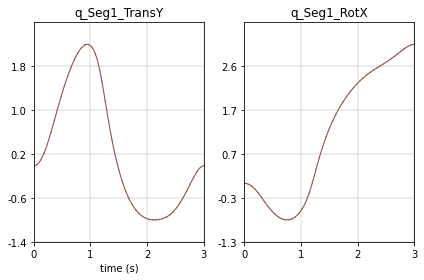

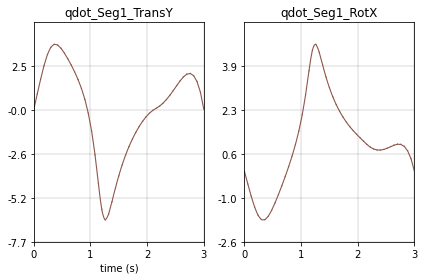

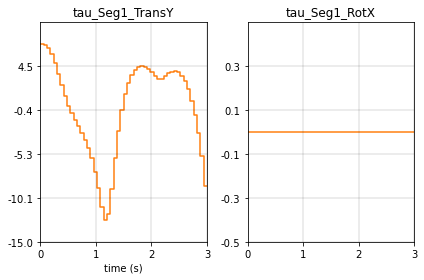

In [15]:
# Now let's print some results to the console and plot some graphs
sol.print()
sol.graphs(automatically_organize=False)